In [116]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [120]:
explanations = {}

with open("explanations_gat.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:  # Check if row is not empty
            index = row[0]
            tensor_str = row[1]
            tensor_list = ast.literal_eval(tensor_str)
            explanations[index] = tensor_list

In [121]:
def get_edge_frequencies(data, explanations):
    edge_frequencies_big = defaultdict(int)
    edge_frequencies_mid = defaultdict(int)
    edge_frequencies_small = defaultdict(int)

    for i, edge_weight in explanations.items():
        edge_weight = torch.tensor(edge_weight)
        edge_index = data.edge_index

        significant_edge_mask_big = edge_weight > 0.5
        significant_edge_mask_mid = edge_weight > 0.1
        significant_edge_mask_small = edge_weight > 0.001
        significant_edge_index_big = edge_index[:, significant_edge_mask_big]
        significant_edge_index_mid = edge_index[:, significant_edge_mask_mid]
        significant_edge_index_small = edge_index[:, significant_edge_mask_small]

        for j in range(significant_edge_index_big.shape[1]):
            edge = tuple(sorted((significant_edge_index_big[0, j].item(), significant_edge_index_big[1, j].item())))
            edge_frequencies_big[edge] += 1

        for j in range(significant_edge_index_mid.shape[1]):
            edge = tuple(sorted((significant_edge_index_mid[0, j].item(), significant_edge_index_mid[1, j].item())))
            edge_frequencies_mid[edge] += 1

        for j in range(significant_edge_index_small.shape[1]):
            edge = tuple(sorted((significant_edge_index_small[0, j].item(), significant_edge_index_small[1, j].item())))
            edge_frequencies_small[edge] += 1

    return edge_frequencies_big, edge_frequencies_mid, edge_frequencies_small


edge_freq_big, edge_freq_mid, edge_freq_small = get_edge_frequencies(data, explanations)

print(sorted(edge_freq_big.items(), key=lambda x: x[1], reverse=True))

[((143, 1701), 35), ((1241, 1701), 33), ((1042, 1628), 31), ((143, 598), 31), ((306, 1367), 31), ((1362, 1914), 30), ((415, 2182), 29), ((598, 1636), 28), ((429, 2001), 28), ((1986, 1993), 28), ((1703, 2238), 27), ((525, 2182), 27), ((111, 1169), 27), ((1040, 1169), 27), ((1169, 1719), 27), ((1169, 1720), 27), ((1169, 1734), 27), ((1441, 1958), 26), ((525, 1628), 26), ((316, 598), 26), ((1257, 2248), 26), ((485, 1042), 25), ((1416, 1602), 25), ((1702, 1703), 25), ((95, 2182), 25), ((756, 1692), 25), ((562, 1483), 25), ((74, 1042), 24), ((24, 598), 24), ((963, 1703), 24), ((706, 963), 24), ((1849, 1914), 24), ((2133, 2182), 24), ((687, 1725), 24), ((919, 1358), 24), ((1169, 1358), 24), ((415, 525), 24), ((310, 1950), 24), ((1464, 1914), 24), ((1095, 1810), 23), ((1702, 2238), 23), ((1703, 1966), 23), ((43, 963), 23), ((805, 963), 23), ((963, 2401), 23), ((52, 2182), 23), ((240, 1692), 23), ((335, 1701), 23), ((687, 2359), 23), ((1042, 2054), 22), ((74, 1416), 22), ((29, 963), 22), ((963

In [122]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
bins_big = divide_into_chunks(edge_freq_big, num_bins)
bins_mid = divide_into_chunks(edge_freq_mid, num_bins)
bins_small = divide_into_chunks(edge_freq_small, num_bins)

## Make sure that the architecture, hyperparams, random seeds and training setup of the model are all identical to the model for which the explanations were generated

In [123]:
from torch_geometric.nn import GATConv, GCNConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [124]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [101]:
# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x
    
# model = GCN(hidden_channels=16)

In [107]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# loss_fn = torch.nn.CrossEntropyLoss()

# def train():
#       model.train()
#       optimizer.zero_grad()
#       out = model(data.x, data.edge_index)
#       loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
#       loss.backward()
#       optimizer.step()
#       return loss

# def test(mask):
#     model.eval()
#     out = model(data.x, data.edge_index)
#     pred = out.argmax(dim=1)
#     test_correct = pred[mask] == data.y[mask]
#     test_acc = int(test_correct.sum()) / int(mask.sum())
#     return test_acc

In [125]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [126]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()
    data.edge_index = keep_edges
    
    return data


def make_undirected(lst):
    lst = torch.tensor(lst)
    flipped = lst.flip(dims=[1])
    combined = torch.cat((lst, flipped), dim=0)
    return combined


def get_logit_diff(perturbed_data):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index)
        out_perturb = model(data.x, perturbed_data.edge_index)
        logit_diff = out_orig - out_perturb
        l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
        return l2_norm

In [127]:
num_samples = 10

results_small = torch.zeros(num_bins, num_samples)
results_mid = torch.zeros(num_bins, num_samples)
results_big = torch.zeros(num_bins, num_samples)

avg_freq_small = []
avg_freq_mid = []
avg_freq_big = []

for i, bin in enumerate(bins_small):
    avg_freq_small.append(np.mean([i[1] for i in bin]))
    for j in range(num_samples):
        half_size = len(bin) // 2
        edges = [i[0] for i in bin]
        sampled_edges = random.sample(edges, half_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_perturbations(data, edges_to_remove)
        results_small[i, j] = get_logit_diff(perturbed_data)

for i, bin in enumerate(bins_mid):
    avg_freq_mid.append(np.mean([i[1] for i in bin]))
    for j in range(num_samples):
        half_size = len(bin) // 2
        edges = [i[0] for i in bin]
        sampled_edges = random.sample(edges, half_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_perturbations(data, edges_to_remove)
        results_mid[i, j] = get_logit_diff(perturbed_data)

for i, bin in enumerate(bins_big):
    avg_freq_big.append(np.mean([i[1] for i in bin]))
    for j in range(num_samples):
        half_size = len(bin) // 2
        edges = [i[0] for i in bin]
        sampled_edges = random.sample(edges, half_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_perturbations(data, edges_to_remove)
        results_big[i, j] = get_logit_diff(perturbed_data)

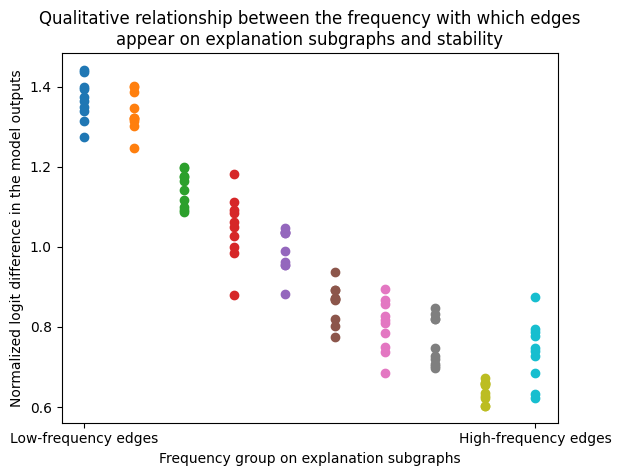

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = results_big[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('Normalized logit difference in the model outputs')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability')
plt.show()

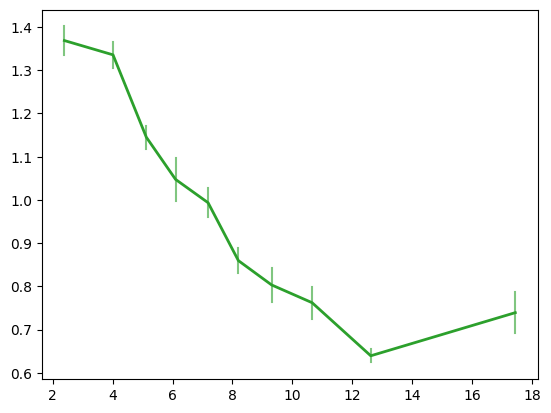

In [129]:
from scipy.stats import sem

results_small_np = results_small.numpy()
results_mid_np = results_mid.numpy()
results_big_np = results_big.numpy()

def plot_with_confidence_intervals(avg_freq, results, label, color):
    # Calculate the mean and standard error of the mean (SEM)
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    # Plot the mean values
    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2)

    # Plot the confidence intervals as vertical lines
    for x, lower, upper in zip(avg_freq, ci_lower, ci_upper):
        plt.plot([x, x], [lower, upper], color=color, alpha=0.6)

# Plotting the results
plt.figure()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# plot_with_confidence_intervals(avg_freq_small, results_small_np, 'Small', colors[0])
# plot_with_confidence_intervals(avg_freq_mid, results_mid_np, 'Mid', colors[1])
plot_with_confidence_intervals(avg_freq_big, results_big_np, 'Big', colors[2])

plt.show()

In [130]:
from torch_geometric.utils import degree

node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(node_degrees[nodes_in_bin]).item())

5.872791290283203
4.933694362640381
5.208279609680176
5.131546974182129
5.376829147338867
5.598750114440918
5.951379776000977
6.46413516998291
7.093442440032959
7.807531356811523


In [131]:
for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    mask = (node_degrees[nodes_in_bin] == 1)
    print(mask.sum().item())

62
171
83
52
46
35
7
12
8
9


In [138]:
import networkx as nx
from torch_geometric.utils import to_networkx

def calculate_closeness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    closeness = nx.closeness_centrality(G)
    return closeness


closeness_centralities = torch.tensor([i[1] for i in calculate_closeness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(closeness_centralities[nodes_in_bin]).item())

0.1627894937992096
0.13430961966514587
0.1475469022989273
0.14637352526187897
0.14692670106887817
0.1463272124528885
0.14773330092430115
0.14967861771583557
0.14969778060913086
0.15322807431221008


In [139]:
def calculate_betweenness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    betweenness = nx.betweenness_centrality(G)
    return betweenness


betweenness_centralities = torch.tensor([i[1] for i in calculate_betweenness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(betweenness_centralities[nodes_in_bin]).item())

0.004246211610734463
0.0032905584666877985
0.003078036243095994
0.002942989580333233
0.0028201518580317497
0.0028571796137839556
0.0029597135726362467
0.003347666235640645
0.003840755671262741
0.004714811686426401


In [140]:
def calculate_eigenvec_centrality(data):
    G = to_networkx(data, to_undirected=True)
    centrality = nx.eigenvector_centrality(G)
    return centrality


eigenvec_centralities = torch.tensor([i[1] for i in calculate_eigenvec_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(eigenvec_centralities[nodes_in_bin]).item())

0.01164113637059927
0.007233402691781521
0.0073810541070997715
0.0062959766946733
0.006511461455374956
0.0064836726523935795
0.006440081633627415
0.006205822341144085
0.007436093408614397
0.008360161446034908


In [142]:
def calculate_clustering_coeff(data):
    G = to_networkx(data, to_undirected=True)
    clustering = nx.clustering(G)
    return clustering


clustering_coeffs = torch.tensor([i[1] for i in calculate_clustering_coeff(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(clustering_coeffs[nodes_in_bin]).item())

0.20944969356060028
0.18034528195858002
0.20606251060962677
0.23692448437213898
0.2647078335285187
0.2761887311935425
0.2894721031188965
0.2740843892097473
0.2638223171234131
0.2693707048892975
